In [27]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [28]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import gpxpy
import haversine as hs
import numpy as np
import statsmodels.api as sm
warnings.simplefilter("ignore")

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [31]:
data = fit.load_pcls(
        athlete_name='zahradnik',
        activity_type='running',
        path_to_load=conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:00<00:00, 1660.59it/s]


In [32]:
# ZONES ADD
for x in range(len(data)):
    data[x] = data[x][df_columns]
    mean_hr = np.mean(data[x].heart_rate)
    if mean_hr < 140:
        zone = 1
    elif mean_hr > 140 and mean_hr < 156:
        zone = 2
    elif mean_hr > 156 and mean_hr < 166:
        zone = 3
    elif mean_hr > 166 and mean_hr < 175:
        zone = 4
    elif mean_hr > 175:
        zone = 5
    data[x]['hr_zone'] = zone

In [33]:
race_index = fit.get_race_index(data, "2022-10-02-10-30") # HRADEC - 1:16 - 1:14
# race_index = fit.get_race_index(data, "2022-11-13-10-59") # VELKA KUNRATICKA 15:20 - 13:20
# race_index = fit.get_race_index(data, "2022-10-08-11-18") # BEROUNKA RUN 90:30 - 95:30
# race_index = fit.get_race_index(data, "2022-12-31-11-00") # SILVESTRAK 18:20 - 17:20
race_index

292

In [34]:
# train_df = fit.clean_data(pd.concat(data[0:len(data)-1]))[df_columns]
# test_df = fit.clean_data(pd.concat(data[len(data)-1:]))[df_columns]
# speed_train = train_df.enhanced_speed
# speed_valid = test_df.enhanced_speed

In [35]:
train_df = fit.clean_data(pd.concat(data[0:race_index]))
test_df = data[race_index]

speed_train = train_df.enhanced_speed
speed_test = test_df.enhanced_speed

heart_train = train_df.heart_rate
heart_test=test_df.heart_rate

cad_train = train_df.cadence
cad_test=test_df.cadence

train_df.drop("heart_rate",axis=1,inplace=True)
train_df.drop("enhanced_speed",axis=1,inplace=True)

test_df.drop("heart_rate",axis=1,inplace=True)
test_df.drop("enhanced_speed",axis=1,inplace=True)
#
train_df.drop("cadence",axis=1,inplace=True)
test_df.drop("cadence",axis=1,inplace=True)

In [36]:
len(train_df),len(test_df), len(train_df.columns), len(test_df.columns)

(586618, 4413, 11, 11)

In [37]:
# from scipy.ndimage import uniform_filter1d
# for x in range(10,110,10):
#     train_df[f'moved_heart_rate_{x}'] = uniform_filter1d(train_df.heart_rate, size=x)
#     test_df[f'moved_heart_rate_{x}'] = uniform_filter1d(test_df.heart_rate, size=x)

In [38]:
from feature_engine.datetime import DatetimeFeatures
train_df['date'] = train_df.index
test_df['date'] = test_df.index
dtf = DatetimeFeatures(features_to_extract=['month','week','hour','minute','second'])
train_df= dtf.fit_transform(train_df)
test_df= dtf.fit_transform(test_df)

In [39]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['slope_steep','slope_ascent','slope_descent']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [40]:
for colname in train_df.columns:
    if 'mean' in colname:
        train_df[colname].fillna(0,inplace=True)
        test_df[colname].fillna(0,inplace=True)

In [41]:
# train_df=train_df[lagged:]
# test_df = test_df[lagged:]
# speed_train = speed_train[lagged:]
# speed_valid = speed_valid[lagged:]

In [42]:
len(train_df),len(test_df), len(train_df.columns), len(test_df.columns)

(586618, 4413, 67, 67)

0.9976554870518528


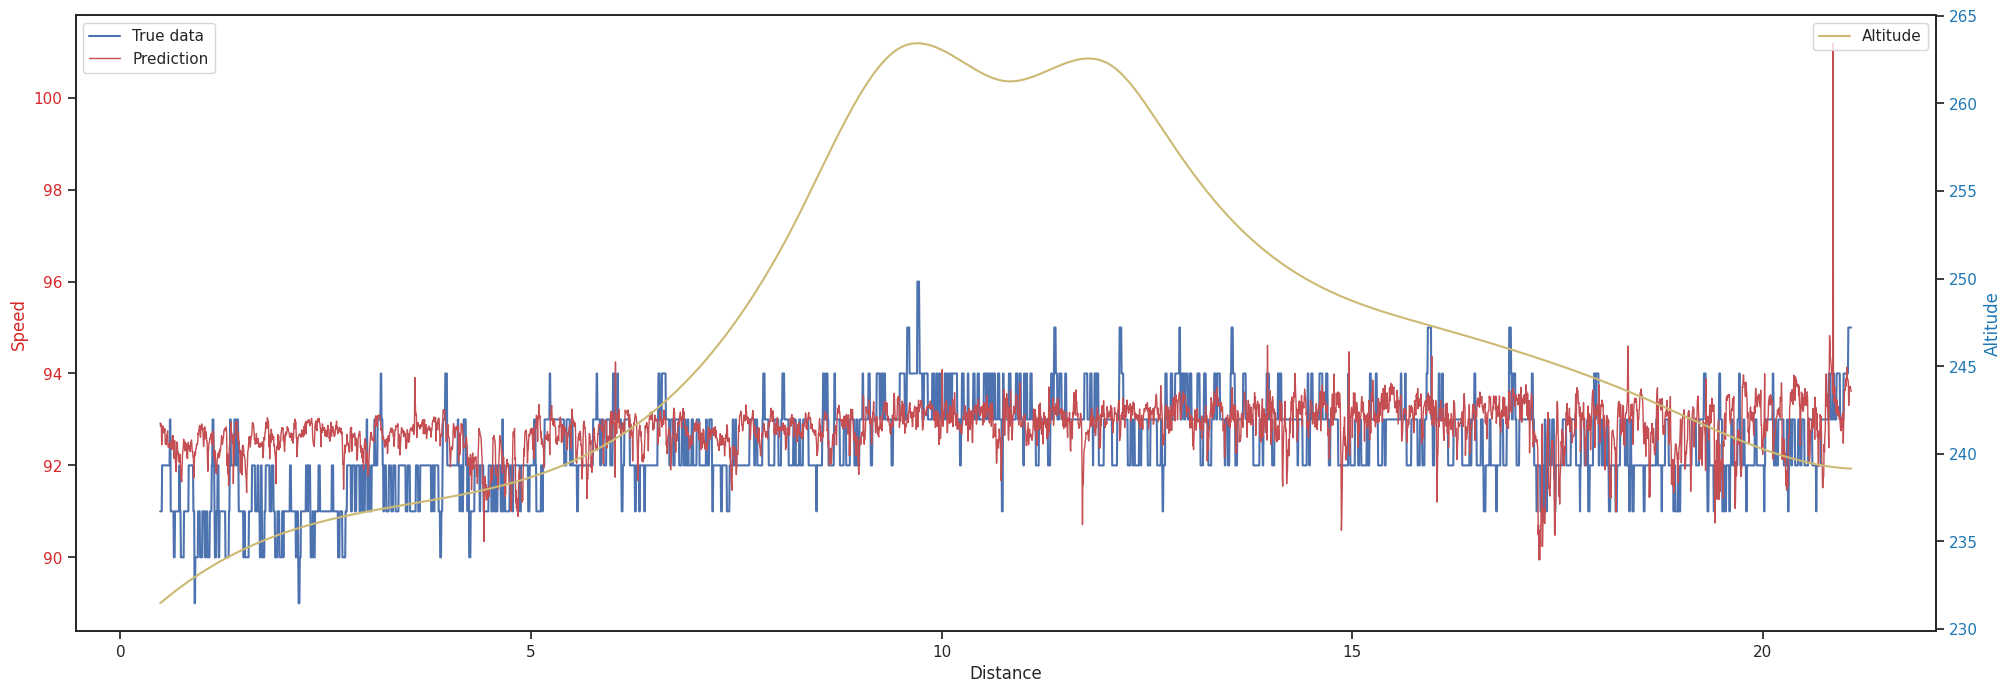

In [53]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, ElasticNetCV
clf = ElasticNetCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, cad_train)
y_pred_cad =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_cad[percent_delay:],endog='enhanced_speed',true_data=cad_test[percent_delay:])
print(evl.rmse(actual=cad_test,predicted=y_pred_cad))

In [54]:
train_df['cadence'] = cad_train
test_df['cadence'] = y_pred_cad

7.695659222008286


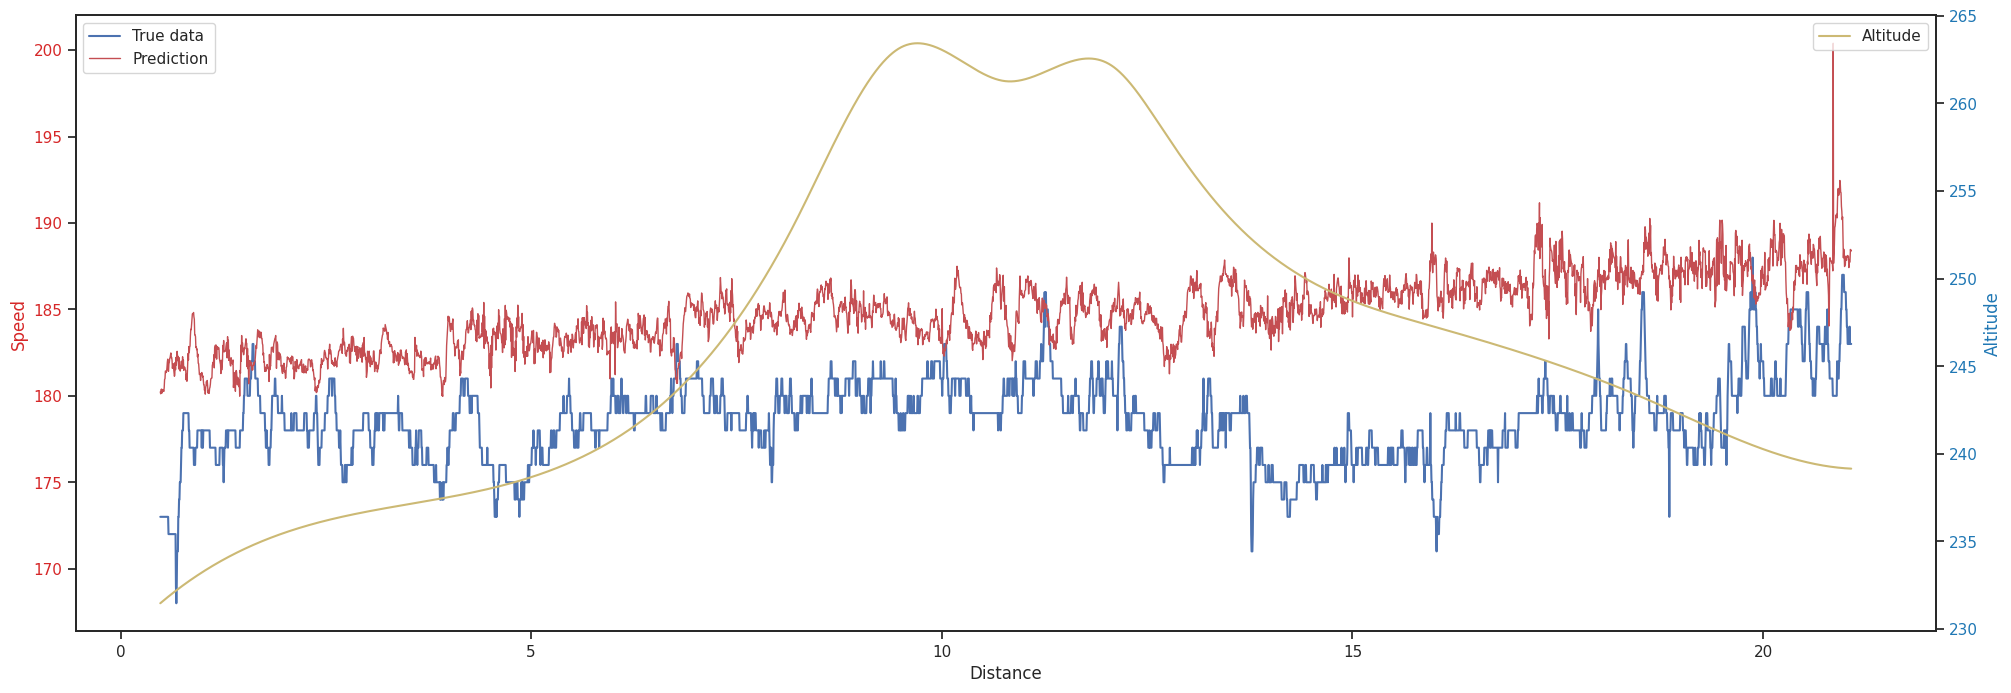

In [55]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, ElasticNetCV
clf = ElasticNetCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, heart_train)
y_pred_hr =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_hr[percent_delay:],endog='enhanced_speed',true_data=heart_test[percent_delay:])
print(evl.rmse(actual=heart_test,predicted=y_pred_hr))

In [56]:
train_df['heart_rate'] = heart_train
test_df['heart_rate'] = y_pred_hr

0.767769839728894


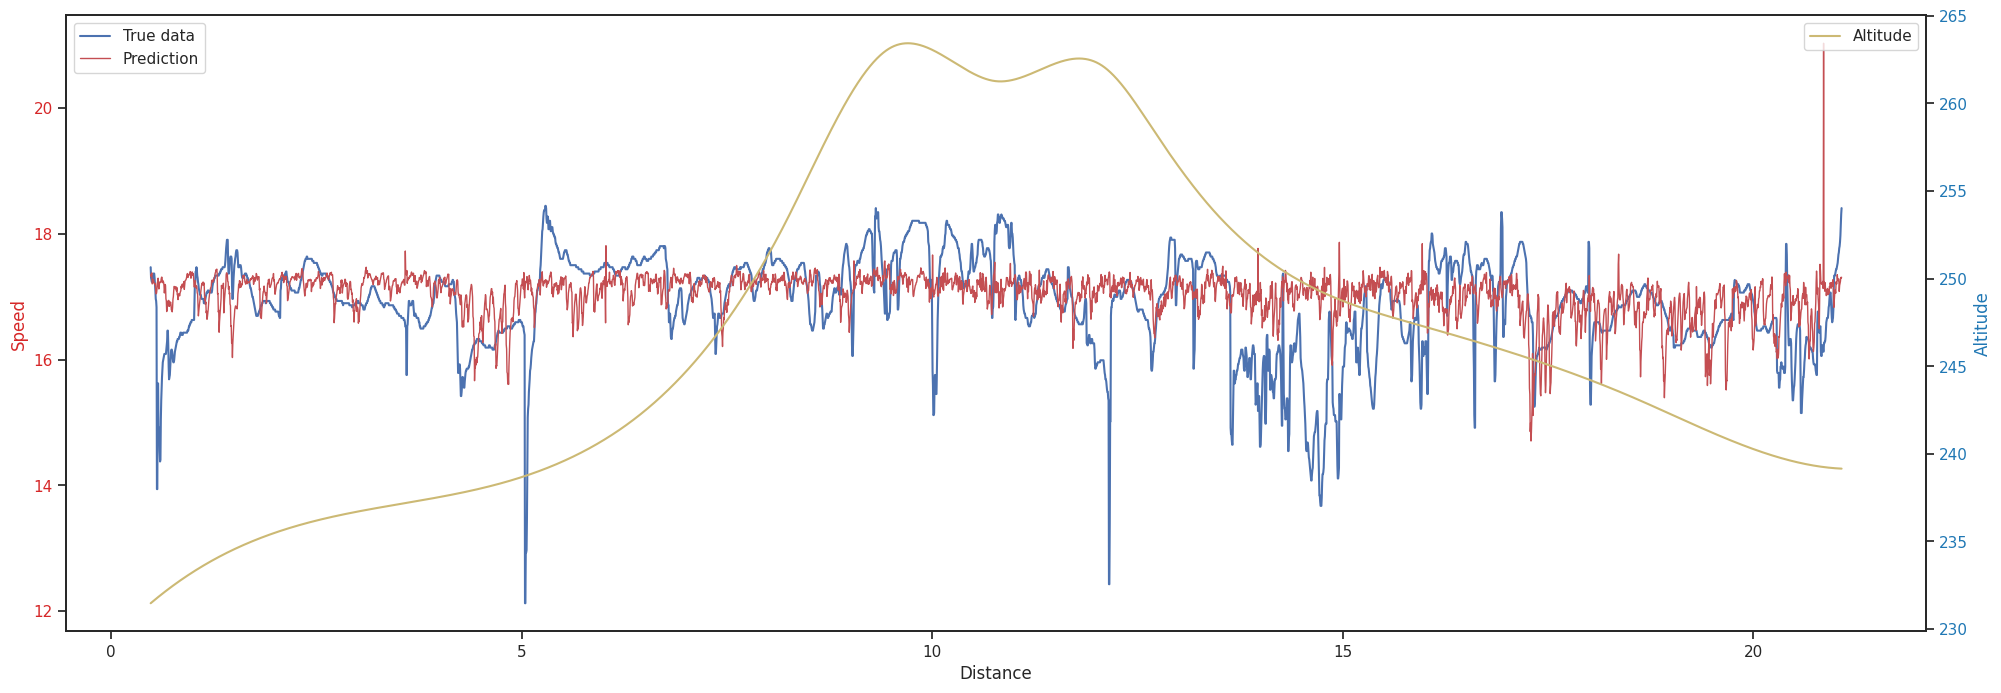

In [57]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, ElasticNetCV
clf = ElasticNetCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, speed_train)
y_pred_ridge =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog='enhanced_speed',true_data=speed_test[percent_delay:])
print(evl.rmse(actual=speed_test,predicted=y_pred_ridge))

In [58]:
import math
np.mean(speed_test),np.mean(y_pred_ridge),max(test_df.distance)
time = ((max(test_df.distance)/1000) / np.mean(y_pred_ridge))*60
minutes = math.floor(time)
seconds = round((time-minutes)*60)
f'Final time: {minutes}:{seconds}'

'Final time: 74:11'

In [49]:
model = sm.OLS(speed_train, train_df)
# model = model.fit()
# model.summary()

In [50]:
# cor = train_df.corr()
# plt.figure(figsize=(12,10))
# sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
# plt.show()

In [51]:
# sns.pairplot(
#     train_df[['heart_rate','distance','enhanced_altitude','cadence','temp','slope_steep']],
#     diag_kind='kde')

In [52]:
# train_df.to_pickle("./train_df.pcl")